In [ ]:
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

import pandas as pd
from scipy.spatial import distance_matrix
import numpy as np
import matplotlib.pyplot as plt

# Sample data
data = {
    'x': [1, 2, 2, 8, 8, 25],
    'y': [2, 2, 3, 8, 9, 30]
}

hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_2nuBB_slim.h5","hits")

# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim.h5","MC/hits")
# hits = pd.read_hdf("/Users/mistryk2/Packages/nexus/ATPC_eminus_0.1mmstep_slim_smear.h5","hits")
display(hits)


: 

,event_id,x,y,z,energy
354,3,-8.766717,-54.443699,2914.584473,0.000650
355,3,-8.705614,-52.390503,2914.808594,0.001650
356,3,-8.716890,-49.380745,2915.330078,0.002575
357,3,-9.272127,-55.547203,2915.537842,0.000525
358,3,-8.930917,-47.259281,2915.546631,0.000475
...,...,...,...,...,...
528,3,-14.726160,6.353005,2996.265869,0.000200
529,3,-13.785117,5.745898,2996.728516,0.000425
530,3,-12.586647,4.972712,2997.317871,0.000625
531,3,-10.802848,3.821905,2998.194824,0.001350


{0: [2], 2: [0, 3], 1: [4], 4: [1, 5], 3: [2, 9], 5: [4, 8], 6: [7, 10], 7: [6], 8: [5], 9: [3], 10: [6], 11: [12], 12: [11, 13], 13: [12, 15], 14: [17], 17: [14, 18], 15: [13], 16: [21], 21: [16, 23], 18: [17], 19: [22], 22: [19], 20: [24], 24: [20, 26], 23: [21, 25], 26: [24, 28], 25: [23], 27: [29], 29: [27, 30], 28: [26], 30: [29, 31], 31: [30, 33], 32: [34], 34: [32, 35], 33: [31, 36], 35: [34], 36: [33], 37: [38], 38: [37, 39], 39: [38], 40: [41], 41: [40], 42: [43], 43: [42, 44], 44: [43, 45], 45: [44], 46: [48], 48: [46, 53], 47: [58], 58: [47, 60], 53: [48, 55], 49: [50, 52], 50: [49], 51: [54], 54: [51], 52: [49, 56], 55: [53], 56: [52], 57: [59], 59: [57], 60: [58], 61: [65], 65: [61, 68], 62: [66], 66: [62], 63: [64], 64: [63, 67], 68: [65], 67: [64], 69: [70], 70: [69, 71], 71: [70], 72: [73], 73: [72], 74: [75], 75: [74, 76], 76: [75, 77], 77: [76, 78], 78: [77], 79: [80], 80: [79], 81: [82], 82: [81], 83: [84], 84: [83], 85: [86], 86: [85, 87], 87: [86, 88], 88: [87, 90]

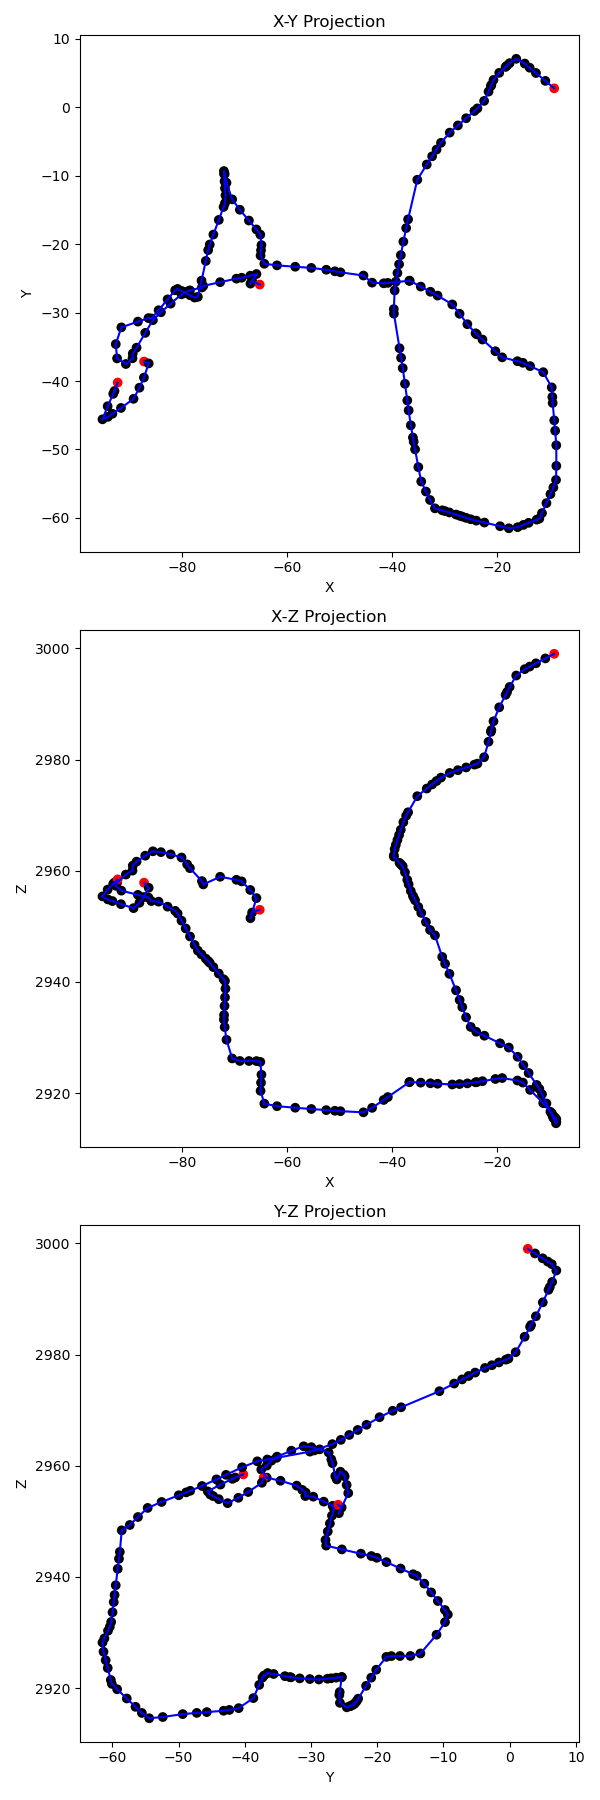

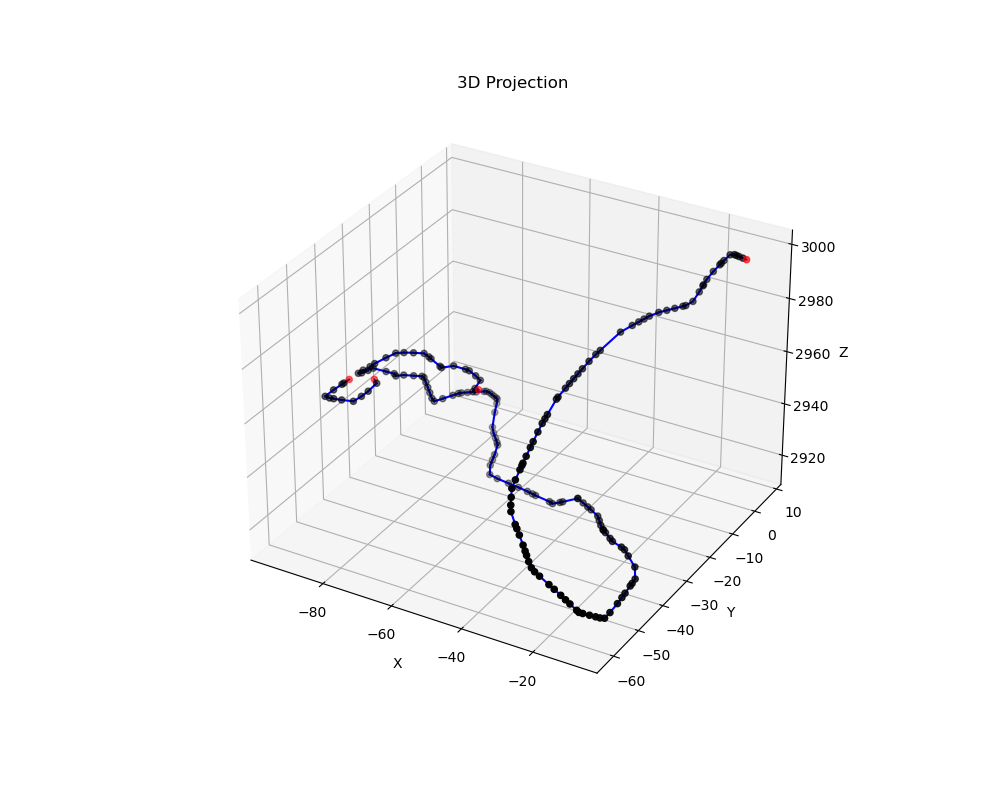

In [28]:
%matplotlib widget

data = hits[hits.event_id == 0]
display(data)
data = data[['x', 'y', 'z',"energy"]]

# shuffle the data to ensure we dont use g4 ordering
data = data.sample(frac=1).reset_index(drop=True)

# then sort it based on the x,y,z
data = data.sort_values(by=['x', "y", "z"]).reset_index(drop=True)

# display(data)


df = pd.DataFrame(data)

# Calculate the distance matrix
dist_matrix = distance_matrix(data[['x', 'y', 'z']], data[['x', 'y', 'z']])

# Initialize connections counter, keeps track of number of connections to each index
connection_count = np.zeros(len(data), dtype=int)

# This is a dict, format is
# index : [connected node 1, connected node 2,...]
connected_nodes = {}

# Define angle threshold in degrees
angle_threshold = 0.5  # Change this value as needed
angle_threshold = np.deg2rad(angle_threshold)

# Function to calculate the angle between two vectors
def calculate_angle(v1, v2):
    dot_product = np.dot(v1, v2)
    norm_v1 = np.linalg.norm(v1)
    norm_v2 = np.linalg.norm(v2)
    angle = np.arccos(dot_product / (norm_v1 * norm_v2))
    return angle

# Function to add connections made
# current and current node index is input
def UpdateConnections(curr_node_idx, conn_node_idx, connected_nodes_, connections_, connection_count_):
    # Add connection between node i and closest_idx
    connections_.append((curr_node_idx, conn_node_idx))
    connection_count_[curr_node_idx] += 1
    connection_count_[conn_node_idx] += 1
    
    # Update connected nodes
    if i in connected_nodes_:
        connected_nodes_[curr_node_idx].append(conn_node_idx)
    else:
        connected_nodes_[curr_node_idx] = [conn_node_idx]
    
    if conn_node_idx in connected_nodes_:
        connected_nodes_[conn_node_idx].append(curr_node_idx)
    else:
        connected_nodes_[conn_node_idx] = [curr_node_idx]

# Function to check if a new connection would form a closed loop
def forms_cycle(node, target, connections_dict):

    query = node # 5 comes in
    prev_node = node # set to 5
    # print(query)

    for index,n in enumerate(range(len(connections_dict))):
        
        # Get the connected nodes
        con_nodes = connections_dict[query]
        # print("Start",query, prev_node, con_nodes)

        # We hit a end-point and it didnt loop
        if (len(con_nodes) == 1):
            return False

        # Get the node that went in the query before
        if con_nodes[1] == prev_node:
            prev_node = query
            query = con_nodes[0]
        else:
            prev_node = query
            query = con_nodes[1]

        if (index == 0):
            query = con_nodes[0]
            prev_node = node


        # If the returned query value is the target then we have looped
        if (query == target):
            return True

    # We looped over everything and found no loops
    return False
    


# Find closest nodes and create connections
connections = []
for i in range(len(data)):
    # Find the index of the closest node (excluding itself)
    closest_idx = np.argpartition(dist_matrix[i], 1)[1]
    
    # Check if the connection already exists
    if closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []):
        
        # Add connection between node i and closest_idx
        UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)


print(connected_nodes)

print(connection_count)


# temp_connections_dict = connected_nodes.copy()
# temp_connection_count = connection_count.copy()
# temp_connections      = connections.copy()
# UpdateConnections(23, 8, temp_connections_dict, temp_connections, temp_connection_count)
# cycle = forms_cycle(23, 8, temp_connections_dict)
# print(cycle)

# Get indices where the value is 1
single_nodes = np.where(connection_count == 1)[0]

# Connect single nodes to the next closest single node if the angle is above the threshold
for i in single_nodes:
    
    # Connections get updated, so this ensures we dont make a connection to a newly formed connection
    if connection_count[i] == 1:
        
        # Find the index of the closest node with one connection (excluding itself)
        sorted_indices = np.argsort(dist_matrix[i])
        
        for closest_idx in sorted_indices[:10]:

            # Check if the index is not itelf and the connection count of the closest index is 1
            if closest_idx != i and connection_count[closest_idx] == 1 and connection_count[i] == 1 and closest_idx not in connected_nodes.get(i, []) and i not in connected_nodes.get(closest_idx, []): 
                
                if dist_matrix[i][closest_idx] < 7:

                    # Temporarily add the connection to check for cycles
                    temp_connections_dict = connected_nodes.copy()
                    temp_connections      = connections.copy()
                    temp_connection_count = connection_count.copy()

                    # print(i,closest_idx,connection_count[i], connection_count[closest_idx], temp_connections_dict[i], temp_connections_dict[closest_idx])
                    UpdateConnections(i, closest_idx, temp_connections_dict, temp_connections, temp_connection_count)                
                    
                    # Check for cycles
                    cycle = forms_cycle(i, closest_idx, temp_connections_dict)

                    temp_connections_dict = {}
                    temp_connections = []
                    temp_connection_count = []
                    
                    if not cycle:
                        UpdateConnections(i, closest_idx, connected_nodes, connections, connection_count)
                        break


print(connection_count)

# Function to plot connections
def plot_connections(ax, x, y, connections, connection_count, x_label, y_label):
    colors = ['r' if count == 1 else 'k' for count in connection_count]
    ax.scatter(x, y, c=colors, marker='o')
    for connection in connections:
        start_node = connection[0]
        end_node = connection[1]
        ax.plot([x[start_node], x[end_node]], [y[start_node], y[end_node]], 'b-')
    ax.set_xlabel(x_label)
    ax.set_ylabel(y_label)
    ax.set_title(f'{x_label}-{y_label} Projection')

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(6, 18))

# Plot xy projection
plot_connections(axs[0], data['x'], data['y'], connections, connection_count, 'X', 'Y')

# Plot xz projection
plot_connections(axs[1], data['x'], data['z'], connections, connection_count, 'X', 'Z')

# Plot yz projection
plot_connections(axs[2], data['y'], data['z'], connections, connection_count, 'Y', 'Z')

plt.tight_layout()
plt.show()

# Plot in 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
colors = ['r' if count == 1 else 'k' for count in connection_count]
ax.scatter(data['x'], data['y'], data['z'], c=colors, marker='o')
for connection in connections:
    start_node = connection[0]
    end_node = connection[1]
    ax.plot([data['x'][start_node], data['x'][end_node]],
            [data['y'][start_node], data['y'][end_node]],
            [data['z'][start_node], data['z'][end_node]], 'b-')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Projection')
plt.show()